In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import utils as u
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def load_file_names(bs_fldr, in_fldr):
    return [os.path.join(in_fldr, f) for f in os.listdir(os.path.join(bs_fldr, in_fldr)) if f.endswith('.npy')]

In [8]:
# build the repo
# collect the files with which repo needs to build    
# construct a class with these file names to read the embeddings
# I need the embeddings, each embedding should have a label and a name, filename
# for each label get N embeddings to keep in the repo

def im2col_sliding_strided(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def build_ref(bs_fldr, file_dict, pool_params, N):

    # for each unique label
    full_emb_df = {}
    all_keys = np.sort(list(file_dict.keys()))
    for k in range(len(all_keys)):

        label = []
        names = []
        all_feat = {}
        for f in file_dict[all_keys[k]]:

            feat = np.load(os.path.join(bs_fldr, f))
            if len(feat) < (pool_params['frames']+pool_params['step']):
                continue
            
            # pool the features according to pool_params
            # for vgg pool all 100 frames, whereas for resnet3D pool only 84 frames. 
            # for then step to another window to pool. The pool function is given in the params
            col_feat = im2col_sliding_strided(feat, (pool_params['frames'], feat.shape[1]), stepsize=pool_params['step']).T
            tmp = pool_params['pool_func'](np.reshape(col_feat, (col_feat.shape[0], pool_params['frames'], feat.shape[1])), axis=1)
            all_feat[f] = tmp.copy()

        all_feat = np.vstack(list(all_feat.values()))
        if N > 0:
            idx = np.random.choice(range(len(all_feat)), np.min([N, len(all_feat)]), replace=False)
            all_feat = all_feat[idx, :].copy()
        cur_df = pd.DataFrame(data=np.zeros((len(all_feat), 1), dtype=np.int32)+k, columns=['label'])
        cur_df['name'] = all_keys[k]
        cur_df['emb'] = all_feat.tolist()
        full_emb_df[k] = cur_df

    # then for each file read all the files 
    return pd.concat(list(full_emb_df.values()), ignore_index=True, sort=False)


def build_FF_Ref(bs_fldr, file_dict, pool_params, N):
    
    # for each unique label
    full_emb_train_df = {}
    full_emb_test_df = {}
    
    all_keys = np.sort(list(file_dict.keys()))
    for k in range(len(all_keys)):

        label = []
        names = []
        train_feat = {}
        test_feat = {}
        for f in file_dict[all_keys[k]]:

            feat = np.load(os.path.join(bs_fldr, f))
            if len(feat) < (pool_params['frames']+pool_params['step']):
                continue
            # pool the features according to pool_params
            # for vgg pool all 100 frames, whereas for resnet3D pool only 84 frames. 
            # for then step to another window to pool. The pool function is given in the params
            col_feat = im2col_sliding_strided(feat, (pool_params['frames'], feat.shape[1]), stepsize=pool_params['step']).T
            tmp = pool_params['pool_func'](np.reshape(col_feat, (col_feat.shape[0], pool_params['frames'], feat.shape[1])), axis=1)
            
            n1 = int(N*len(tmp))
            train_feat[f] = tmp[:n1, :].copy()
            test_feat[f] = tmp[n1:, :].copy()
            
        full_emb_train_df[all_keys[k]] = train_feat.copy()
        full_emb_test_df[all_keys[k]] = test_feat.copy()

    # then for each file read all the files 
    return full_emb_train_df, full_emb_test_df

# train and test split
def train_test(bs_fldr):

    train_ldr_dict = u.load_dict_file('/data/home/shruti/voxceleb/motion_signature/data/utils/leaders_100_train.txt')
    test_ldr_dict = u.load_dict_file('/data/home/shruti/voxceleb/motion_signature/data/utils/leaders_100_test.txt')

    # add folders to the test label dict
    fake_name = ['bo_imposter', 'bo_faceswap', 'bo_UWfake', 
                  'bs_faceswap', 'bs_imposter', 'ew_faceswap', 
                  'ew_imposter', 'dt_faceswap', 'dt_imposter', 
                  'hc_faceswap', 'hc_imposter', 'FF_orig']

    # test and train fakes
    for k in fake_name:
        cur_files = load_file_names(bs_fldr, k)
        cur_files = np.sort(cur_files)
        
        # partition
        n1 = int(0.1*len(cur_files))
        n2 = len(cur_files) - n1
        
        train_ldr_dict[k] = cur_files[:n1]
        test_ldr_dict[k] = cur_files[n1:]
        
    return train_ldr_dict, test_ldr_dict

def train_test_FF(bs_fldr):
    
    # add folders to the test label dict
    fake_name = ['FF_orig', 'FF_Deepfakes', 'FF_FaceSwap', 'FF_Face2Face', 'FF_NeuralTextures']
    
    train_ldr_dict = {}
    # test and train fakes
    for k in fake_name:
        cur_files = load_file_names(bs_fldr, k)
        train_ldr_dict[k] = np.sort(cur_files)
        
    return train_ldr_dict


# get the cosine similarity
def get_results(train_repo, test_repo):
    
    train_emb = np.array(list(train_repo['emb']))
    test_emb = np.array(list(test_repo['emb']))
    
    # normalize the embeddings
    train_emb = train_emb - np.mean(train_emb, axis=1, keepdims=True)
    train_emb = train_emb/ np.linalg.norm(train_emb, axis=1, keepdims=True)
    
    test_emb = test_emb - np.mean(test_emb, axis=1, keepdims=True)
    test_emb = test_emb/ np.linalg.norm(test_emb, axis=1, keepdims=True)
    
    max_val = np.zeros((len(test_emb), )) - 1
    max_id = np.zeros((len(test_emb), )) - 1
    for i in range(len(test_emb)):
        if i%1000:
            print(i, len(test_emb))
        cur_sim = np.sum(train_emb * test_emb[[i], :], axis=1)
        max_val[i] = np.max(cur_sim)
        max_id[i] = np.argmax(cur_sim)
    
    result_df = pd.DataFrame(data=[test_repo['name'].iloc[i] for i in range(len(max_id))], columns=['true_name'])
    result_df['pred_name'] = [train_repo['name'].iloc[i] for i in max_id]
    result_df['pred_label'] = [train_repo['label'].iloc[i] for i in max_id]
    result_df['dist'] = [sim_mat[max_id[i], i] for i in range(len(max_id))]
    
    return result_df



### Face Forensics

In [4]:
def test_FF_half(bs_fldr, pool_params):
    
    train_files = train_test_FF(bs_fldr)

    # these are the table values
    train_ldrs = ['FF_orig', 'FF_Deepfakes', 'FF_FaceSwap', 'FF_Face2Face', 'FF_NeuralTextures']
    train_repo, test_repo = build_FF_Ref(bs_fldr, {f: train_files[f] for f in train_ldrs}, pool_params, 0.5)
    
    train_cases = 'FF_orig'
    test_names = ['FF_Deepfakes', 'FF_FaceSwap', 'FF_Face2Face', 'FF_NeuralTextures']
    test_cases =  [[['FF_Deepfakes'], ['FF_FaceSwap'], ['FF_Face2Face'], ['FF_NeuralTextures']]]
    
    results = {}
    src_emb = np.vstack(list(train_repo[train_cases].values()))
    
    idx = np.random.choice(range(len(src_emb)), np.min([5000, len(src_emb)]), replace=False)
    src_emb = src_emb[idx, :].copy()
    print(f'source embedding {src_emb.shape}')
    for k in train_repo.keys():
        
        cur_emb = test_repo[k]
        results[k] = {}
        for j in cur_emb.keys():
            
            print(cur_emb[j].shape)
            sim_mat = cosine_similarity(src_emb, 
                                        cur_emb[j],
                                        dense_output=True)
            results[k][j] = np.max(sim_mat, axis=0)
            
        sns.distplot(np.concatenate(list(results[k].values()), axis=0), label=k)
        
    plt.legend()
    plt.show()

    # for each case
    auc_results = np.zeros((1, len(test_names))) + np.nan
    pos_dist = np.concatenate(list(results[train_cases].values()), axis=0)
    for t in range(len(test_names)):

        neg_dist = np.concatenate(list(results[test_names[t]].values()), axis=0)
        pred = np.log(np.concatenate([pos_dist, neg_dist], axis=0))
        lbl = np.concatenate([np.ones_like(pos_dist), np.zeros_like(neg_dist)])
        fpr, tpr, thresholds = roc_curve(lbl, pred)
        auc_results[0, t] = auc(fpr, tpr)

    return auc_results

### Leaders Unseen Identities

In [5]:
def test_unseen_identities(bs_fldr, pool_params):

    train_files, test_files = train_test(bs_fldr)

    # these are the table values
    train_ldrs = ['bo', 'bs', 'ew', 'hc', 'dt', 'jb', 'cb', 'pb', 'kh', 'br']
    test_names = ['diff', 'faceswap', 'imposter']
    test_ldrs =  [[['br', 'bs', 'cb', 'dt', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig'], 
                   ['bo_faceswap'], ['bo_imposter']],
                  [['bo', 'br', 'cb', 'dt', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig'], 
                   ['bs_faceswap'], ['bs_imposter']],
                  [['bo', 'br', 'bs', 'cb', 'dt', 'hc', 'jb', 'kh', 'pb', 'FF_orig'], 
                   ['ew_faceswap'], ['ew_imposter']],
                  [['bo', 'br', 'bs', 'cb', 'dt', 'ew', 'jb', 'kh', 'pb', 'FF_orig'], 
                   ['hc_faceswap'], ['hc_imposter'] ],
                  [['bo', 'br', 'bs', 'cb', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig'], 
                   ['dt_faceswap'], ['dt_imposter'] ],
                  [['bo', 'br', 'bs', 'cb', 'dt', 'ew', 'hc', 'kh', 'pb', 'FF_orig']],
                  [['bo', 'br', 'bs', 'dt', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig']],
                  [['bo', 'br', 'bs', 'cb', 'dt', 'ew', 'hc', 'jb', 'kh', 'FF_orig']],
                  [['bo', 'br', 'bs', 'cb', 'dt', 'ew', 'hc', 'jb', 'pb', 'FF_orig']], 
                  [['bo', 'bs', 'cb', 'dt', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig']]
                 ]

    # for each case
    results = np.zeros((len(train_ldrs), len(test_names))) + np.nan
    for l in range(len(train_ldrs)):

        train_repo = build_ref(bs_fldr, {f: train_files[f] for f in [train_ldrs[l]]}, pool_params, 30000)
        pos_test_repo = build_ref(bs_fldr, {f: test_files[f] for f in [train_ldrs[l]]}, pool_params, -1)
        pos_result = get_results(train_repo, pos_test_repo)
        for t in range(len(test_ldrs[l])):

            neg_test_repo = build_ref(bs_fldr, {f: test_files[f] for f in test_ldrs[l][t]}, pool_params, -1)
            neg_results = get_results(train_repo, neg_test_repo)

            pred = np.log(np.concatenate([np.array(pos_result['dist']), 
                                          np.array(neg_results['dist'])], axis=0))
            lbl = np.concatenate([np.ones_like(np.array(pos_result['dist'])), 
                                  np.zeros_like(np.array(neg_results['dist']))])
            fpr, tpr, thresholds = roc_curve(lbl, pred)
            results[l, t] = auc(fpr, tpr)
            #print(f'{train_ldrs[l]} {test_names[t]} auc: {results[l, t]}')

    results_df = pd.DataFrame(data=results, columns=test_names)
    results_df['leader_name'] = train_ldrs
    return results_df

### Leaders Multiple Identities

In [6]:
def test_multiple_identities(bs_fldr, pool_params):
    
    train_files, test_files = train_test(bs_fldr)

    # these are the table values
    train_ldrs = ['bo', 'bs', 'ew', 'hc', 'dt', 'jb', 'cb', 'pb', 'kh', 'br']
    test_ldrs =  ['bo', 'br', 'bs', 'cb', 'dt', 'ew', 'hc', 'jb', 'kh', 'pb', 'FF_orig', 
                  'bo_faceswap', 'bo_imposter', 'bs_faceswap', 'bs_imposter', 'dt_faceswap', 'dt_imposter', 
                  'ew_faceswap', 'ew_imposter', 'hc_faceswap', 'hc_imposter']
    
    train_repo = build_ref(bs_fldr, {f: train_files[f] for f in train_ldrs}, pool_params, 30000)
    test_repo = build_ref(bs_fldr, {f: test_files[f] for f in test_ldrs}, pool_params, -1)
    
    full_results = get_results(train_repo, test_repo)
    
    # these are the table values
    test_names = ['diff', 'faceswap', 'imposter']
    test_cases =  [[['FF_orig'], ['bo_faceswap'], ['bo_imposter']],
                  [['FF_orig'], ['bs_faceswap'], ['bs_imposter']],
                  [['FF_orig'], ['ew_faceswap'], ['ew_imposter']],
                  [['FF_orig'], ['hc_faceswap'], ['hc_imposter'] ],
                  [['FF_orig'], ['dt_faceswap'], ['dt_imposter'] ],
                  [['FF_orig']],
                  [['FF_orig']],
                  [['FF_orig']],
                  [['FF_orig']], 
                  [['FF_orig']] ]

    # for each case
    results = np.zeros((len(train_ldrs), len(test_names))) + np.nan
    for l in range(len(train_ldrs)):

        pos_dist = np.array(full_results['dist'][full_results['true_name']==train_ldrs[l]])        
        for t in range(len(test_cases[l])):
            
            neg_dist = np.array(full_results['dist'][full_results['true_name'].isin(test_cases[l][t])])

            pred = np.log(np.concatenate([pos_dist, neg_dist], axis=0))
            lbl = np.concatenate([np.ones_like(pos_dist), np.zeros_like(neg_dist)])
            fpr, tpr, thresholds = roc_curve(lbl, pred)
            results[l, t] = auc(fpr, tpr)
            #print(f'{train_ldrs[l]} {test_names[t]} auc: {results[l, t]}')

    results_df = pd.DataFrame(data=results, columns=test_names)
    results_df['leader_name'] = train_ldrs
    
    # pivot table
    confusion_mat = full_results.pivot_table(values='dist', 
                                             index='true_name', columns='pred_name', 
                                             aggfunc=lambda x: len(x))
    confusion_mat = confusion_mat/np.nansum(np.array(confusion_mat), axis=1, keepdims=True)
    
    return results_df, confusion_mat

# VGG test

In [9]:
vgg_pool_len = 100
vgg_step = 5
vgg_func = [np.mean]

### Face Forensics

source embedding (5000, 4096)


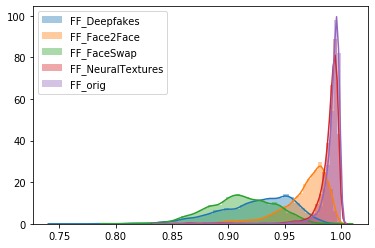

array([[0.98572009, 0.98894974, 0.92337588, 0.61573965]])

source embedding (5000, 4096)


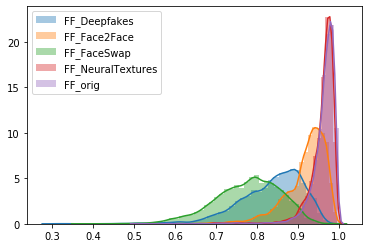

array([[0.97060649, 0.98932566, 0.82008054, 0.54777536]])

In [8]:
results_FF_half_vgg = {}
for fnc in range(len(vgg_func)):
    vgg_pool_params = {'frames': vgg_pool_len, 'step': vgg_step, 'pool_func': vgg_func[fnc]}
    results_FF_half_vgg[fnc] = test_FF_half('/data/home/shruti/voxceleb/vgg/leaders/', vgg_pool_params)
    display(results_FF_half_vgg[fnc])

In [8]:

results_FF_half_vgg = {}
for fnc in range(len(vgg_func)):
    vgg_pool_params = {'frames': vgg_pool_len, 'step': vgg_step, 'pool_func': vgg_func[fnc]}
    results_FF_half_vgg[fnc] = test_FF_half('/data/home/shruti/voxceleb/vgg/leaders/', vgg_pool_params)
    display(results_FF_half_vgg[fnc])
    

source embedding (46195, 4096)


array([[0.99656196, 0.99755553, 0.95200753, 0.65040807]])

source embedding (46195, 4096)


array([[0.98271009, 0.9948434 , 0.85319647, 0.57844159]])

source embedding (46195, 4096)


array([[0.99656196, 0.99755553, 0.95200766, 0.65040764]])

### Leaders Unseen Identities

In [ ]:

results_unseen_id_vgg = {}
for fnc in range(len(vgg_func)):
    vgg_pool_params = {'frames': vgg_pool_len, 'step': vgg_step, 'pool_func': vgg_func[fnc]}
    results_unseen_id_vgg[fnc] = test_unseen_identities('/data/home/shruti/voxceleb/vgg/leaders/', vgg_pool_params)
    display(results_unseen_id_vgg[fnc])
    

1 57296
2 57296
3 57296
4 57296
5 57296
6 57296
7 57296
8 57296
9 57296
10 57296
11 57296
12 57296
13 57296
14 57296
15 57296
16 57296
17 57296
18 57296
19 57296
20 57296
21 57296
22 57296
23 57296
24 57296
25 57296
26 57296
27 57296
28 57296
29 57296
30 57296
31 57296
32 57296
33 57296
34 57296
35 57296
36 57296
37 57296
38 57296
39 57296
40 57296
41 57296
42 57296
43 57296
44 57296
45 57296
46 57296
47 57296
48 57296
49 57296
50 57296
51 57296
52 57296
53 57296
54 57296
55 57296
56 57296
57 57296
58 57296
59 57296
60 57296
61 57296
62 57296
63 57296
64 57296
65 57296
66 57296
67 57296
68 57296
69 57296
70 57296
71 57296
72 57296
73 57296
74 57296
75 57296
76 57296
77 57296
78 57296
79 57296
80 57296
81 57296
82 57296
83 57296
84 57296
85 57296
86 57296
87 57296
88 57296
89 57296
90 57296
91 57296
92 57296
93 57296
94 57296
95 57296
96 57296
97 57296
98 57296
99 57296
100 57296
101 57296
102 57296
103 57296
104 57296
105 57296
106 57296
107 57296
108 57296
109 57296
110 57296
111 5729

832 57296
833 57296
834 57296
835 57296
836 57296
837 57296
838 57296
839 57296
840 57296
841 57296
842 57296
843 57296
844 57296
845 57296
846 57296
847 57296
848 57296
849 57296
850 57296
851 57296
852 57296
853 57296
854 57296
855 57296
856 57296
857 57296
858 57296
859 57296
860 57296
861 57296
862 57296
863 57296
864 57296
865 57296
866 57296
867 57296
868 57296
869 57296
870 57296
871 57296
872 57296
873 57296
874 57296
875 57296
876 57296
877 57296
878 57296
879 57296
880 57296
881 57296
882 57296
883 57296
884 57296
885 57296
886 57296
887 57296
888 57296
889 57296
890 57296
891 57296
892 57296
893 57296
894 57296
895 57296
896 57296
897 57296
898 57296
899 57296
900 57296
901 57296
902 57296
903 57296
904 57296
905 57296
906 57296
907 57296
908 57296
909 57296
910 57296
911 57296
912 57296
913 57296
914 57296
915 57296
916 57296
917 57296
918 57296
919 57296
920 57296
921 57296
922 57296
923 57296
924 57296
925 57296
926 57296
927 57296
928 57296
929 57296
930 57296
931 57296


1594 57296
1595 57296
1596 57296
1597 57296
1598 57296
1599 57296
1600 57296
1601 57296
1602 57296
1603 57296
1604 57296
1605 57296
1606 57296
1607 57296
1608 57296
1609 57296
1610 57296
1611 57296
1612 57296
1613 57296
1614 57296
1615 57296
1616 57296
1617 57296
1618 57296
1619 57296
1620 57296
1621 57296
1622 57296
1623 57296
1624 57296
1625 57296
1626 57296
1627 57296
1628 57296
1629 57296
1630 57296
1631 57296
1632 57296
1633 57296
1634 57296
1635 57296
1636 57296
1637 57296
1638 57296
1639 57296
1640 57296
1641 57296
1642 57296
1643 57296
1644 57296
1645 57296
1646 57296
1647 57296
1648 57296
1649 57296
1650 57296
1651 57296
1652 57296
1653 57296
1654 57296
1655 57296
1656 57296
1657 57296
1658 57296
1659 57296
1660 57296
1661 57296
1662 57296
1663 57296
1664 57296
1665 57296
1666 57296
1667 57296
1668 57296
1669 57296
1670 57296
1671 57296
1672 57296
1673 57296
1674 57296
1675 57296
1676 57296
1677 57296
1678 57296
1679 57296
1680 57296
1681 57296
1682 57296
1683 57296
1684 57296

### Leaders Multiple Identities

In [ ]:

results_multiple_id_vgg = {}
confusion_multiple_id_vgg = {}
for fnc in range(len(vgg_func)):
    vgg_pool_params = {'frames': vgg_pool_len, 'step': vgg_step, 'pool_func': vgg_func[fnc]}
    results_unseen_id_vgg[fnc], confusion_multiple_id_vgg[fnc] = test_multiple_identities('/data/home/shruti/voxceleb/vgg/leaders/', 
                                                                             vgg_pool_params)
    display(results_unseen_id_vgg[fnc])
    display(confusion_multiple_id_vgg[fnc])
    

# ResNext-3D test

In [ ]:
res_pool_len = 84
res_step = 5
res_func = [np.mean, np.max, np.sum]

### Face Forensics

In [ ]:

results_FF_half_res = {}
for fnc in range(len(vgg_func)):
    res_pool_params = {'frames': res_pool_len, 'step': res_step, 'pool_func': res_func[fnc]}
    results_FF_half_res[fnc] = test_FF_half('/data/home/shruti/voxceleb/resnet3D/leaders/', res_pool_params)
    display(results_FF_half_res[fnc])



### Leaders Unseen Identities

In [ ]:

results_unseen_id_res = {}
for fnc in range(len(vgg_func)):
    res_pool_params = {'frames': res_pool_len, 'step': res_step, 'pool_func': res_func[fnc]}
    results_unseen_id_res[fnc] = test_unseen_identities('/data/home/shruti/voxceleb/resnet3D/leaders/', res_pool_params)
    display(results_unseen_id_res[fnc])
    

### Leaders Multiple Identities

In [ ]:

results_multiple_id_res = {}
confusion_multiple_id_res = {}
for fnc in range(len(vgg_func)):
    res_pool_params = {'frames': res_pool_len, 'step': res_step, 'pool_func': res_func[fnc]}
    results_unseen_id_res[fnc], confusion_multiple_id_res[fnc] = \
    test_multiple_identities('/data/home/shruti/voxceleb/resnet3D/leaders/', 
                                                                             res_pool_params)
    display(results_unseen_id_res[fnc])
    display(confusion_multiple_id_res[fnc])
    